# Reconhecimento de Vegetais com Redes Neurais

## Base de dados do kaggle; Keras , Tensorflow, MobileNetV3Small

# 1.0 Importando as bibliotecas

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import PIL
import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt


### 1.1 Fazendo a extração do arquivo zip, origem kaggle (Vegetable Image Dataset)

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('vegetais.zip')
zip_ref.extractall('/content')
zip_ref.close()

### 1.2 Padronizando o tamanho das imagens, largura e altura

In [8]:
batch_size = 32
image_width = 224
image_height = 224

### 1.3 Criando o caminho dos diretórios das imagens, treino, teste e validação
##### 1.3.1 Contagem de imagens para treino = 15 mil

In [12]:
train_dir = pathlib.Path('/content/Vegetable Images/train')
val_dir = pathlib.Path('/content/Vegetable Images/validation')
test_dir = pathlib.Path('/content/Vegetable Images/test')
train_image_count = len(list(train_dir.glob('*/*.jpg')))
train_image_count

15000

##### 1.3.2 Contagem de imagens para Validação = 3 mil

In [14]:
val_image_count = len(list(val_dir.glob('*/*.jpg')))
val_image_count

3000

##### 1.3.3 Contagem de imagens para Teste = 3 mil

In [15]:
test_image_count = len(list(test_dir.glob('*/*.jpg')))
test_image_count

3000

# 2.0 Pré-processamento das imagens do diretório
### 2.1 Número de Classes por diretório:15

In [16]:
train_ds = keras.preprocessing.image_dataset_from_directory( train_dir, seed=123,image_size=(image_height, image_width), batch_size=batch_size)
val_ds = keras.preprocessing.image_dataset_from_directory( val_dir, seed=123, image_size=(image_height, image_width), batch_size=batch_size)
test_ds = keras.preprocessing.image_dataset_from_directory( test_dir, seed=123, image_size=(image_height, image_width), batch_size=batch_size)

Found 15000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.


### 2.2 Nome das classes: 
### 2.3 Vegetais: feijão, bitter gourd, bottle gourd, berinjela, brócolis, repolho, pimentão, cenoura, couve-flor, pepino, mamão, batata, abóbora, rabanete e tomate.

In [17]:
class_names = train_ds.class_names
class_names

['Bean',
 'Bitter_Gourd',
 'Bottle_Gourd',
 'Brinjal',
 'Broccoli',
 'Cabbage',
 'Capsicum',
 'Carrot',
 'Cauliflower',
 'Cucumber',
 'Papaya',
 'Potato',
 'Pumpkin',
 'Radish',
 'Tomato']

### 2.4 A Visualização de alguns vegetais no arquivo de treino pré-processado

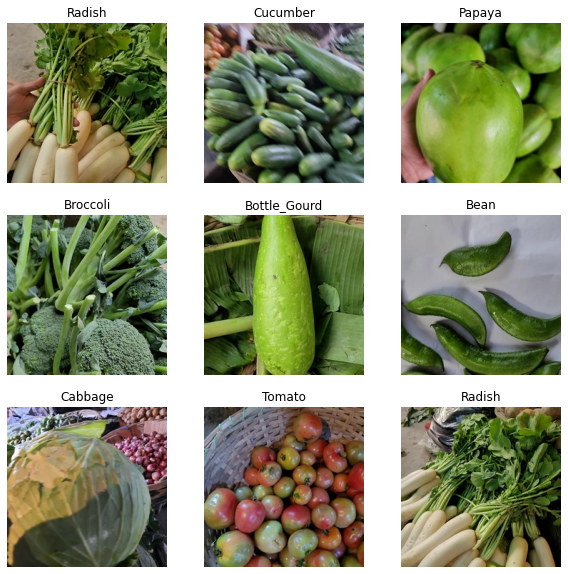

In [27]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(200):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

# 3.0 Usando a arquitetura MobileNetV3Small do Keras para a construção do modelo 

In [37]:
base_model = keras.applications.MobileNetV3Small(input_shape=(224, 224, 3), classes=400, include_top=False,
weights='imagenet')
base_model

### 3.1 Summary do modelo

In [36]:
base_model.trainable = False
base_model.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling_2[0][0]']            
                                )                                                                 
                                                                                   

### 3.2 Data Augmentation (usando diferentes posições das imagens para aumentar a base de dados) para camadas keras a serem treinadas 

In [38]:
data_augmentation = keras.models.Sequential([
keras.layers.RandomFlip('horizontal'),
keras.layers.RandomRotation(0.2)
])

# 4.0 Camadas das redes neurais do modelo 

In [39]:
num_classes = len(class_names)
inputs = keras.Input(shape=(image_width, image_height, 3))

#x = data_augmentation(inputs)

x = keras.applications.mobilenet_v3.preprocess_input(inputs)
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)

outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
model = keras.Model(inputs, outputs)

### 4.1 Complilando o modelo com seleção de parâmetros

In [40]:

model.compile(optimizer='adam',
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3small (Functiona  (None, 7, 7, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 576)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 576)               0         
                                                                 
 dense (Dense)               (None, 15)                8655      
                                                                 
Total params: 947,775
Trainable params: 935,663
Non-trainable

### 4.2 Selecionando a melhor época para parar
# 5.0 Predição do Modelo

In [43]:
initial_epochs = 5
early_stop = keras.callbacks.EarlyStopping(patience=1, restore_best_weights=False)

history = model.fit(train_ds,
validation_data=val_ds,
epochs=initial_epochs,
callbacks=[early_stop])

Epoch 1/10
469/469 [==============================] - 1382s 3s/step - loss: 0.2309 - accuracy: 0.9299 - val_loss: 0.0506 - val_accuracy: 0.9847
Epoch 2/10
469/469 [==============================] - 1253s 3s/step - loss: 0.0564 - accuracy: 0.9835 - val_loss: 0.0412 - val_accuracy: 0.9887
Epoch 3/10
469/469 [==============================] - 1235s 3s/step - loss: 0.0463 - accuracy: 0.9859 - val_loss: 0.0082 - val_accuracy: 0.9977
Epoch 4/10
469/469 [==============================] - 1221s 3s/step - loss: 0.0564 - accuracy: 0.9841 - val_loss: 0.0280 - val_accuracy: 0.9920


### 5.1 Gráfico de acurácia do modelo (treino e validação) por época e os viéses (loss) perdas por época

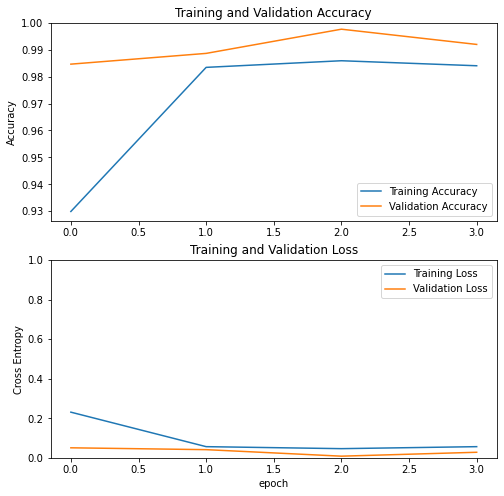

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')


plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### 5.2 Aplicando imagens para testar o modelo de predição

1/1 [==============================] - 1s 1000ms/step


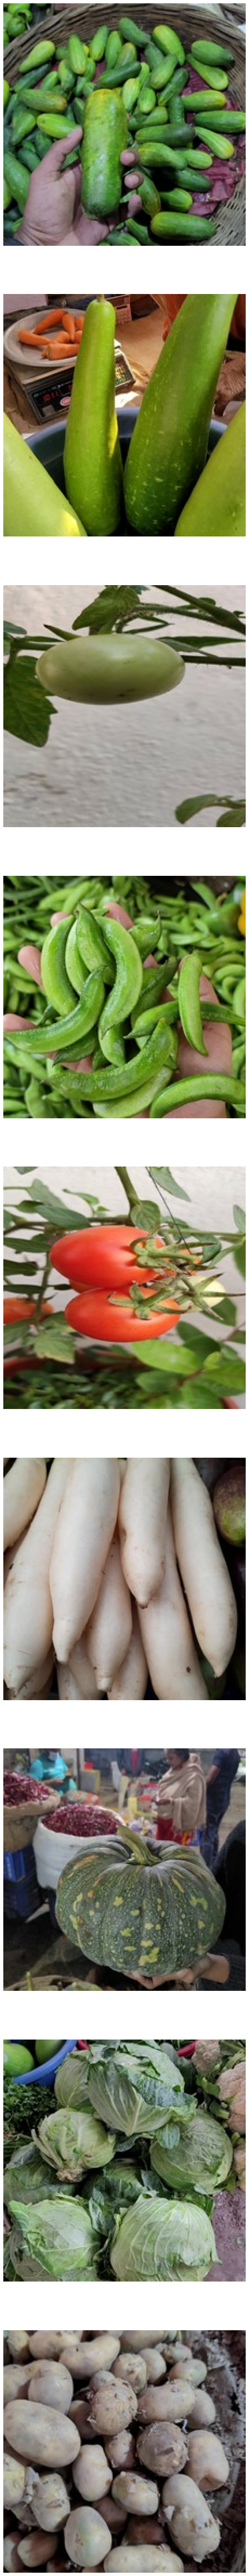

In [51]:
plt.figure(figsize=(10, 100))
for images, labels in test_ds.take(15):
    prediction = model.predict(images,batch_size=32)
    for i in range(9):
        ax = plt.subplot(9, 1, i+1)
        pred = np.argmax(prediction[i])
        plt.imshow(images[i].numpy().astype('uint8'))
        
        plt.axis('off')

# 6.0 Resultados do modelo de predição de vegetais:
### 6.1 Acurácia do modelo = 99 % e Loss=0.03


In [52]:
results = model.evaluate(test_ds, verbose=0)

In [53]:
print(" Test Loss: {:.5f}".format(results[0]))
print(" Accuracy on the test set: {:.2f}%".format(results[1] * 100))

 Test Loss: 0.03718
 Accuracy on the test set: 99.00%
